In [118]:
using Distributions
using ForwardDiff
using LinearAlgebra
using Random
using StatsFuns
using StatsPlots
default(fmt=:png)

parameter_C(P) = dot(P, P)
parameter_T(P) = sum(p -> p^3, P)
simpson_diversity_index(P) = 1 - parameter_C(P)

estimator_of_C(n, K) = sum(k -> k*(k-1), K) / (n*(n-1))
estimator_of_T(n, K) = sum(k -> k*(k-1)*(k-2), K) / (n*(n-1)*(n-2))
estimator_of_simpson_diversity_index(n, K) = 1 - estimator_of_C(n, K)
estimator_of_simpson_diversity_index(K) = estimator_of_simpson_diversity_index(sum(K), K)

function minimum_of_estimator_of_C(n, r)
    k = n/r
    r*k*(k-1)/(n*(n-1))
end

function _coefficients_abc(n)
    a = 4(n-2)/(n*(n-1))
    b = (4n-6)/(n*(n-1))
    c = 2/(n*(n-1))
    (; a, b, c)
end

function variance_of_estimator_of_C(n, P)
    (; a, b, c) = _coefficients_abc(n)
    C = parameter_C(P)
    T = parameter_T(P)
    max(0, a*T - b*C^2 + c*C)
end
std_of_estimator_of_C(n, P) = √variance_of_estimator_of_C(n, P)

# See https://arxiv.org/abs/2310.03439
function estimator_of_variance_of_estimator_of_C(n, K)
    (; a, b, c) = _coefficients_abc(n)
    Ĉ = estimator_of_C(n, K)
    T̂ = estimator_of_T(n, K)
    max(0, (a*T̂ - b*Ĉ^2 + c*Ĉ) / (1-b))
end
estimator_of_variance_of_estimator_of_C(K) = estimator_of_variance_of_estimator_of_C(sum(K), K)

estimator_of_std_of_estimator_of_C(n, K) = √estimator_of_variance_of_estimator_of_C(n, K)
estimator_of_std_of_estimator_of_C(K) = estimator_of_std_of_estimator_of_C(sum(K), K)

function sim_sdi(mult::Multinomial; niters=10^5,
        #varhatfunc = estimator_of_variance_of_estimator_of_C, 
        varhatfunc = variance_of_sdi_in_bootstrap, 
    )
    n = ntrials(mult)
    sdihat = zeros(niters)
    varhat = zeros(niters)
    Ktmp = [rand(mult) for _ in 1:Threads.nthreads()]
    Threads.@threads :static for i in 1:niters
        tid = Threads.threadid()
        K = rand!(mult, Ktmp[tid])
        sdihat[i] = estimator_of_simpson_diversity_index(n, K)
        varhat[i] = varhatfunc(n, K)
    end
    (; sdihat, varhat)
end

multinomial(K) = Multinomial(sum(K), K/sum(K)) 

safediv(x, y) = x == 0 ? zero(x/y) : isinf(x) ? oftype(x/y, x) : x/y

function pvalue_sdi(n, K, sdi; linkfunc=identity,
        #sehatfunc = estimator_of_std_of_estimator_of_C, 
        sehatfunc = std_of_sdi_in_bootstrap, 
    )
    dlinkfunc(x) = ForwardDiff.derivative(linkfunc, x)
    sdihat = estimator_of_simpson_diversity_index(n, K)
    sehat = sehatfunc(n, K)
    if sehat == 0
        sdihat == sdi ? one(sdi) : zero(sdi)
    else
        z = safediv(linkfunc(sdihat) - linkfunc(sdi), abs(dlinkfunc(sdihat)) * sehat)
        2ccdf(Normal(), abs(z))
    end
end

pvalue_sdi(K, sdi;
        linkfunc=identity,
        #sehatfunc = estimator_of_std_of_estimator_of_C, 
        sehatfunc = std_of_sdi_in_bootstrap,         
    ) = pvalue_sdi(sum(K), K, sdi; linkfunc, sehatfunc)

function pvalues_sdi_bootstrap(data, sdi₀; L=10^4)
    r = length(data)
    n, P = sum(data), data/sum(data)
    dist_bootstrap = Multinomial(n, P)
    Ktmp = rand(dist_bootstrap)
    c = zeros(Int, length(sdi₀))
    d = zeros(Int, length(sdi₀))
    for i in 1:L
        K = rand!(dist_bootstrap, Ktmp)
        D̂ = 1 - (n*estimator_of_C(n, K) - 1) / (n-1)
        @. c += D̂ ≤ sdi₀
        @. d += D̂ ≥ sdi₀
    end
    @. min(1, 2c/L, 2d/L)
end

function pvalue_sdi_bootstrap(data, sdi₀; L=10^4)
    r = length(data)
    n, P = sum(data), data/sum(data)
    dist_bootstrap = Multinomial(n, P)
    Ktmp = rand(dist_bootstrap)
    c = 0
    d = 0
    for i in 1:L
        K = rand!(dist_bootstrap, Ktmp)
        D̂ = 1 - (n*estimator_of_C(n, K) - 1) / (n - 1)
        c += D̂ ≤ sdi₀
        d += D̂ ≥ sdi₀
    end
    min(1, 2c/L, 2d/L)
end

variance_of_sdi_in_bootstrap(n, data) = (n/(n-1))^2 * variance_of_estimator_of_C(n, data/n)
#variance_of_sdi_in_bootstrap(n, data) = variance_of_estimator_of_C(n, data/n)
#variance_of_sdi_in_bootstrap(n, data) = (n/(n-1))*(1 - (4n-6)/(n*(n-1))) * variance_of_estimator_of_C(n, data/n)
variance_of_sdi_in_bootstrap(data) = variance_of_sdi_in_bootstrap(sum(data), data)
std_of_sdi_in_bootstrap(n, data) = √variance_of_sdi_in_bootstrap(n, data)
std_of_sdi_in_bootstrap(data) = std_of_sdi_in_bootstrap(sum(data), data)

function make_link_logit(n, r)
#     function link_logit(x)
#         m = minimum_of_estimator_of_C(n, r)
#         t = (1 - m - x)/(1 - m)
#         logit(t)
#     end
    link_logit(x) = -logit(x)
    link_logit
end

make_link_logit(mult::Multinomial) = make_link_logit(ntrials(mult), length(probs(mult)))

function make_link_log(n, r)
#     function link_log(x)
#         m = minimum_of_estimator_of_C(n, r)
#         t = 1 - m - x
#         log(t)
#     end
    link_log(x) = log(1 - x)
    link_log
end

make_link_log(mult::Multinomial) = make_link_log(ntrials(mult), length(probs(mult)))

function plot_pval(data; sdimin=0, sdimax=1,
        #sehatfunc = estimator_of_std_of_estimator_of_C, 
        sehatfunc = std_of_sdi_in_bootstrap, 
    )
    n, r = sum(data), length(data)
    link_logit = make_link_logit(n, r)
    link_log = make_link_log(n, r)
    sdis = range(sdimin, sdimax, 200)
    pval_bs = pvalues_sdi_bootstrap(data, sdis)
    plot()
    plot!(sdi -> pvalue_sdi(n, data, sdi; linkfunc=identity, sehatfunc), sdimin, sdimax; label="identity")
    plot!(sdi -> pvalue_sdi(n, data, sdi; linkfunc=link_logit, sehatfunc), sdimin, sdimax; label="logit", ls=:dash)
    plot!(sdi -> pvalue_sdi(n, data, sdi; linkfunc=link_log, sehatfunc), sdimin, sdimax; label="log", ls=:dashdot)
    plot!(sdis, pval_bs; label="bootstrap", ls=:dashdotdot)
end

function sim_pval(mult::Multinomial;
        niters=10^4,
        n = ntrials(mult),
        P = probs(mult),
        r = length(P),
        sdi = simpson_diversity_index(P),
        linkfunc0 = identity,
        linkfunc1 = make_link_logit(n, r),
        linkfunc2 = make_link_log(n, r),
        L = 10^4,
        #sehatfunc = estimator_of_std_of_estimator_of_C, 
        sehatfunc = std_of_sdi_in_bootstrap, 
    )
    n = ntrials(mult)
    pval0 = zeros(niters)
    pval1 = zeros(niters)
    pval2 = zeros(niters)
    pval_bs = zeros(niters)
    Ktmp = [rand(mult) for _ in 1:Threads.nthreads()]
    Threads.@threads :static for i in 1:niters
        tid = Threads.threadid()
        K = rand!(mult, Ktmp[tid])
        pval0[i] = pvalue_sdi(n, K, sdi; linkfunc=linkfunc0, sehatfunc)
        pval1[i] = pvalue_sdi(n, K, sdi; linkfunc=linkfunc1, sehatfunc)
        pval2[i] = pvalue_sdi(n, K, sdi; linkfunc=linkfunc2, sehatfunc)
        pval_bs[i] = pvalue_sdi_bootstrap(K, sdi; L)
    end
    (; pval0, pval1, pval2, pval_bs)
end

_ecdf(A, x) = count(≤(x), A) / length(A)

function plot_pval(mult::Multinomial;
        niters=10^4,
        n = ntrials(mult),
        P = probs(mult),
        r = length(P),
        sdi = simpson_diversity_index(P),
        linkfunc0 = identity,
        linkfunc1 = make_link_logit(n, r),
        linkfunc2 = make_link_log(n, r),
        L = 10^4,
        #sehatfunc = estimator_of_std_of_estimator_of_C, 
        sehatfunc = std_of_sdi_in_bootstrap, 
    )
    (; pval0, pval1, pval2, pval_bs) = sim_pval(mult; niters, n, P, r, sdi, linkfunc0, linkfunc1, linkfunc2, L, sehatfunc)
    plot()
    plot!(α -> _ecdf(pval0, α), 0, 0.1; label="$linkfunc0")
    plot!(α -> _ecdf(pval1, α), 0, 0.1; label="$linkfunc1", ls=:dash)
    plot!(α -> _ecdf(pval2, α), 0, 0.1; label="$linkfunc2", ls=:dashdot)
    plot!(α -> _ecdf(pval_bs, α), 0, 0.1; label="bootstrap", ls=:dashdotdot)
    plot!(identity; label="", c=:gray, ls=:dot)
    plot!(xtick=0:0.01:1)
    plot!(size=(400, 400))
end

plot_pval (generic function with 2 methods)

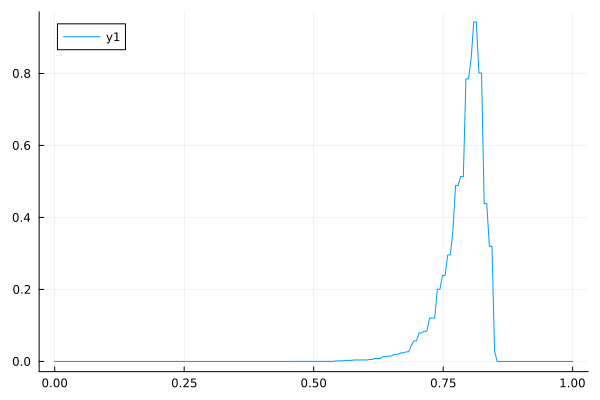

In [105]:
data = [4, 4, 4, 4]
sdis = range(0, 1, 200)
pval_bs = pvalues_sdi_bootstrap(data, sdis)
plot(sdis, pval_bs)

0.6 ^ 2 + 0.2 ^ 2 + 0.1 ^ 2 * 2 = 0.42000000000000004
C = parameter_C(data / n) = 0.25
(6 * 5 + 2 * 1) / (10 * 9) = 0.35555555555555557
Ĉ = estimator_of_C(n, data) = 0.2
mean(sdi_bootstrap) = 0.1999716711111111


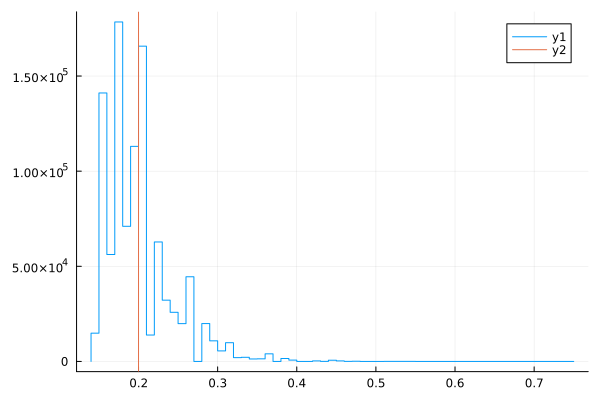

In [106]:
function sample_bootstrap(data; L=10^4)
    sdi_bootstrap = zeros(L)
    r = length(data)
    n, P = sum(data), data/sum(data)
    dist_bootstrap = Multinomial(n, P)
    Ktmp = rand(dist_bootstrap)
    for i in 1:L
        K = rand!(dist_bootstrap, Ktmp)
        sdi_bootstrap[i] = (n*estimator_of_C(n, K) - 1) / (n - 1)
    end
    sdi_bootstrap
end

#data = [30; 13; 9; 8; fill(7, 3); fill(6, 2); 5; fill(2, 3); fill(1, 13)]
data = [4, 4, 4, 4]
n = sum(data)
r = length(data)

sdi_bootstrap = sample_bootstrap(data; L=10^6)

@show 0.6^2+0.2^2+0.1^2*2
@show C = parameter_C(data/n)
@show (6*5 + 2*1)/(10*9)
@show Ĉ = estimator_of_C(n, data)
@show mean(sdi_bootstrap)

stephist(sdi_bootstrap; bin=100)
vline!([Ĉ])

In [107]:
data = [4, 3, 3, 3]
@show 1 - minimum_of_estimator_of_C(sum(data), length(data))
@show estimator_of_simpson_diversity_index(data)
@show estimator_of_std_of_estimator_of_C(data)
@show std_of_sdi_in_bootstrap(data);

1 - minimum_of_estimator_of_C(sum(data), length(data)) = 0.8125
estimator_of_simpson_diversity_index(data) = 0.8076923076923077
estimator_of_std_of_estimator_of_C(data) = 0.0
std_of_sdi_in_bootstrap(data) = 0.0571970855892935


sdihat = estimator_of_simpson_diversity_index(n, data) = 0.8
sehat = estimator_of_std_of_estimator_of_C(n, data) = 0.0
sehat = std_of_sdi_in_bootstrap(n, data) = 0.04216370213557839

sdihat = estimator_of_simpson_diversity_index(n, data) = 0.4285714285714286
sehat = estimator_of_std_of_estimator_of_C(n, data) = 0.20203050891044225
sehat = std_of_sdi_in_bootstrap(n, data) = 0.19280044518052225

sdihat = estimator_of_simpson_diversity_index(n, data) = 0.47058823529411764
sehat = estimator_of_std_of_estimator_of_C(n, data) = 0.1281064806733412
sehat = std_of_sdi_in_bootstrap(n, data) = 0.12507630481939644

sdihat = estimator_of_simpson_diversity_index(n, data) = 0.7833333333333333
sehat = estimator_of_std_of_estimator_of_C(n, data) = 0.0
sehat = std_of_sdi_in_bootstrap(n, data) = 0.05312023399100629

sdihat = estimator_of_simpson_diversity_index(n, data) = 0.7777777777777778
sehat = estimator_of_std_of_estimator_of_C(n, data) = 0.0
sehat = std_of_sdi_in_bootstrap(n, data) = 0.047723038253

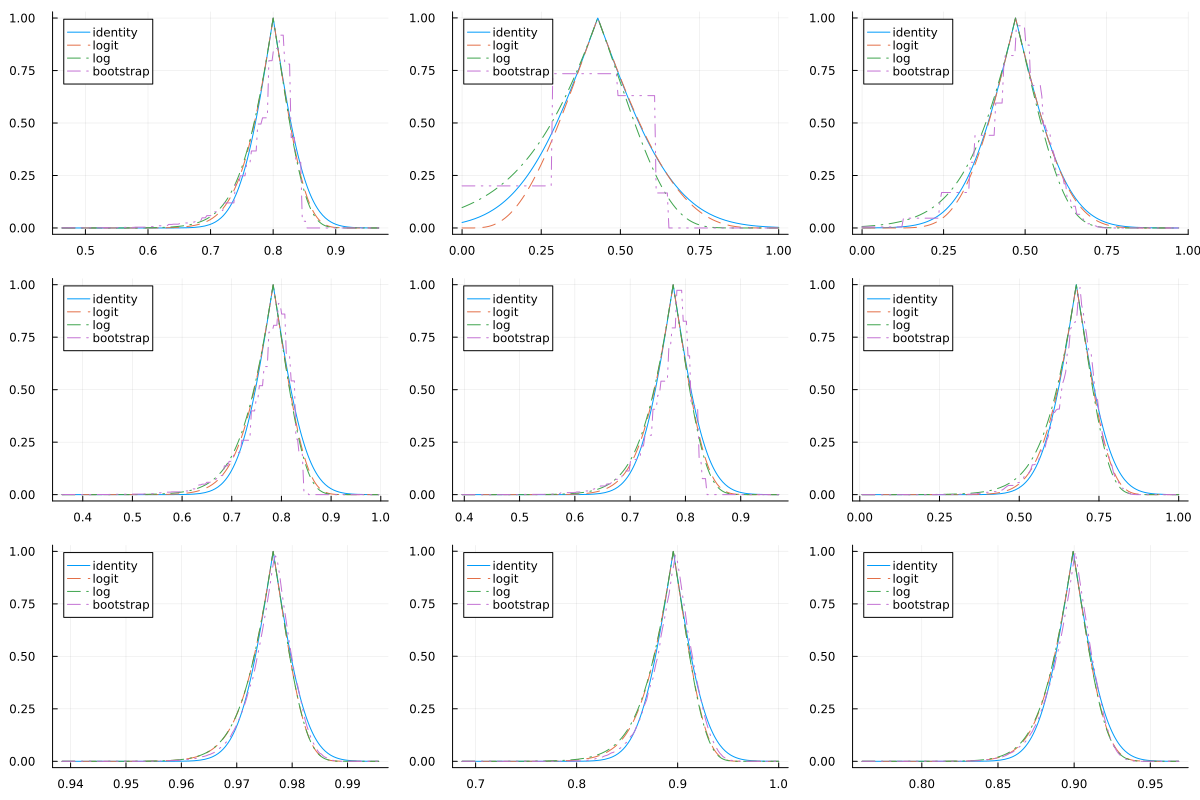

In [151]:
data1 = [4, 4, 4, 4]
data2 = [6, 2]
data3 = [12, 4, 1]
data4 = [5, 5, 3, 3]
data5 = [6, 5, 4, 3]
data6 = [10, 6, 2, 1, 1]
table1 = [9; 8; 7; 6; 5; 5; fill(4, 3); fill(3, 4); fill(2, 9); fill(1, 35)]
table2 = [37; 5; fill(4, 2); fill(3, 4); fill(2, 8); fill(1, 39)]
table3 = [30; 13; 9; 8; fill(7, 3); fill(6, 2); 5; fill(2, 3); fill(1, 13)]

datasets = [data1, data2, data3, data4, data5, data6, table1, table2, table3]

PP = []
for data in datasets
    n, r = sum(data), length(data)
    @show sdihat = estimator_of_simpson_diversity_index(n, data)
    @show sehat = estimator_of_std_of_estimator_of_C(n, data)
    @show sehat = std_of_sdi_in_bootstrap(n, data)
    println()
    if sehat == 0
        sdimin, sdimax = 0, 1
    else
        sdimin, sdimax = max(0, sdihat-8sehat), min(1, sdihat+4sehat)
    end
    P = plot_pval(data; sdimin, sdimax,
        #sehatfunc = estimator_of_std_of_estimator_of_C, 
        sehatfunc = std_of_sdi_in_bootstrap, 
    )
    push!(PP, P)
end

plot!(PP...; size=(1200, 800), layout=(3, 3), legend=:topleft)

sdihat = estimator_of_simpson_diversity_index(n, data) = 0.8
sehat = estimator_of_std_of_estimator_of_C(n, data) = 0.0
sehat = std_of_sdi_in_bootstrap(n, data) = 0.04216370213557839

sdihat = estimator_of_simpson_diversity_index(n, data) = 0.4285714285714286
sehat = estimator_of_std_of_estimator_of_C(n, data) = 0.20203050891044225
sehat = std_of_sdi_in_bootstrap(n, data) = 0.19280044518052225

sdihat = estimator_of_simpson_diversity_index(n, data) = 0.47058823529411764
sehat = estimator_of_std_of_estimator_of_C(n, data) = 0.1281064806733412
sehat = std_of_sdi_in_bootstrap(n, data) = 0.12507630481939644

sdihat = estimator_of_simpson_diversity_index(n, data) = 0.7833333333333333
sehat = estimator_of_std_of_estimator_of_C(n, data) = 0.0
sehat = std_of_sdi_in_bootstrap(n, data) = 0.05312023399100629

sdihat = estimator_of_simpson_diversity_index(n, data) = 0.7777777777777778
sehat = estimator_of_std_of_estimator_of_C(n, data) = 0.0
sehat = std_of_sdi_in_bootstrap(n, data) = 0.047723038253

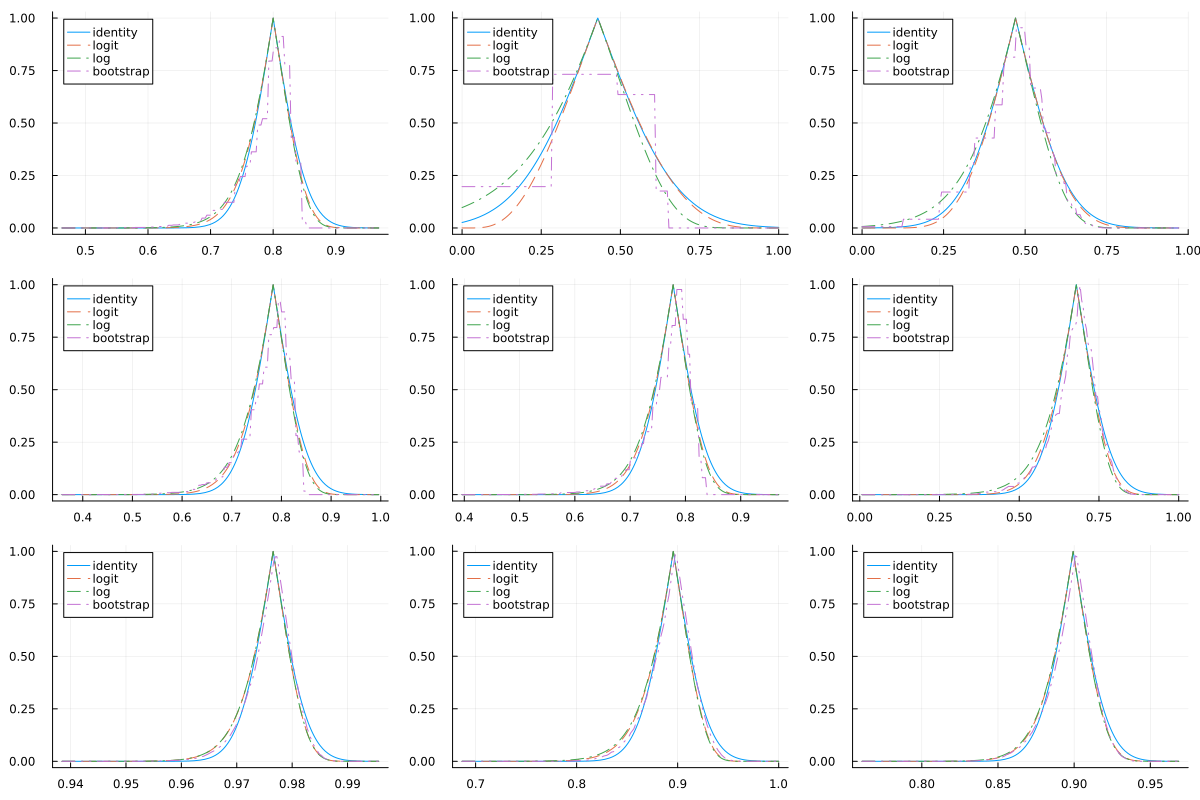

In [152]:
data1 = [4, 4, 4, 4]
data2 = [6, 2]
data3 = [12, 4, 1]
data4 = [5, 5, 3, 3]
data5 = [6, 5, 4, 3]
data6 = [10, 6, 2, 1, 1]
table1 = [9; 8; 7; 6; 5; 5; fill(4, 3); fill(3, 4); fill(2, 9); fill(1, 35)]
table2 = [37; 5; fill(4, 2); fill(3, 4); fill(2, 8); fill(1, 39)]
table3 = [30; 13; 9; 8; fill(7, 3); fill(6, 2); 5; fill(2, 3); fill(1, 13)]

datasets = [data1, data2, data3, data4, data5, data6, table1, table2, table3]

PP = []
for data in datasets
    n, r = sum(data), length(data)
    @show sdihat = estimator_of_simpson_diversity_index(n, data)
    @show sehat = estimator_of_std_of_estimator_of_C(n, data)
    @show sehat = std_of_sdi_in_bootstrap(n, data)
    println()
    if sehat == 0
        sdimin, sdimax = 0, 1
    else
        sdimin, sdimax = max(0, sdihat-8sehat), min(1, sdihat+4sehat)
    end
    P = plot_pval(data; sdimin, sdimax,
        #sehatfunc = estimator_of_std_of_estimator_of_C, 
        sehatfunc = std_of_sdi_in_bootstrap, 
    )
    push!(PP, P)
end

plot!(PP...; size=(1200, 800), layout=(3, 3), legend=:topleft)

n = ntrials(mult) = 117
P = probs(mult) = [0.2564102564102564, 0.1111111111111111, 0.07692307692307693, 0.06837606837606838, 0.05982905982905983, 0.05982905982905983, 0.05982905982905983, 0.05128205128205128, 0.05128205128205128, 0.042735042735042736, 0.017094017094017096, 0.017094017094017096, 0.017094017094017096, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548, 0.008547008547008548]
r = length(P) = 26
linkfunc = make_link_logit(n, r) = var"#link_logit#167"()
  0.541030 seconds (2.11 M allocations: 280.381 MiB, 31.95% gc time, 124.01% compilation time)

simpson_diversity_index(P) = 0.8916648403827891
mean(sdihat) = 0.8916474388446803

variance_of_estimator_of_C(n, P) = 0.00029492032138581645
var(sdihat) = 0.0002946041438583208
mean(varhat) = 0.00031201476103360397

α = 0.0

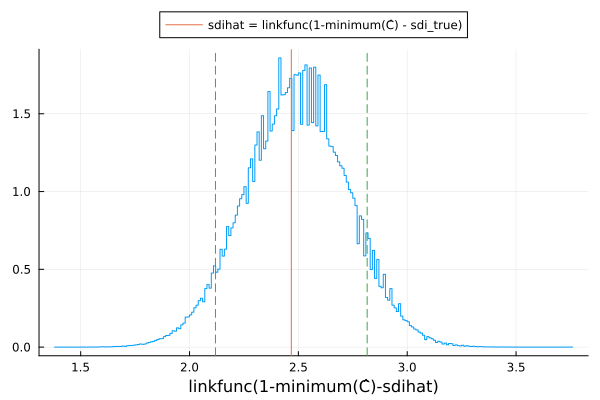

In [153]:
data = table3
mult = multinomial(data)
@show n = ntrials(mult)
@show P = probs(mult)
@show r = length(P)
@show linkfunc = make_link_logit(n, r)
dlinkfunc(x) = ForwardDiff.derivative(linkfunc, x)
@time (; sdihat, varhat) = sim_sdi(mult::Multinomial; niters=10^6)
println()
@show simpson_diversity_index(P)
@show mean(sdihat)
println()
@show variance_of_estimator_of_C(n, P)
@show var(sdihat)
@show mean(varhat)
println()
@show α = 0.05
@show w = cquantile(Normal(), α/2)
println()
@show m = minimum_of_estimator_of_C(n, r)
@show sdi_true = simpson_diversity_index(P)
@show se_true = std_of_estimator_of_C(n, P)
@show se_true_linked = abs(dlinkfunc(sdi_true)) * se_true
bin = :auto
stephist(linkfunc.((1 - m) .- sdihat); norm=true, bin, label="")
plot!(xguide="linkfunc(1-minimum(Ĉ)-sdihat)")
plot!(legend=:outertop)
vline!([linkfunc(1-m-sdi_true)]; label="sdihat = linkfunc(1-minimum(Ĉ) - sdi_true)")
vline!([linkfunc(1-m-sdi_true) - w*se_true_linked, linkfunc(1-m-sdi_true) + w*se_true_linked]; label="", ls=:dash)

data = data1 = [4, 4, 4, 4]
n = 16
r = 4
round.(P; sigdigits = 2) = [0.25, 0.25, 0.25, 0.25]
  0.178023 seconds (573.90 k allocations: 22.605 MiB, 6.64% gc time, 421.17% compilation time)


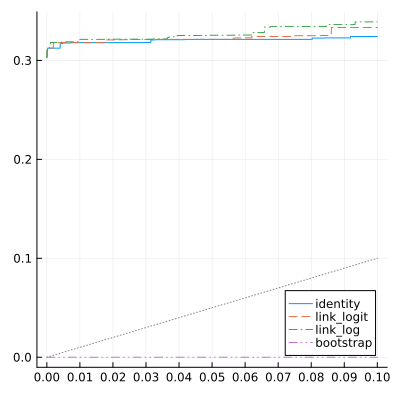

In [142]:
@show data = data1
mult = multinomial(data)
n, P = params(mult)
r = length(P)
@show n r
@show round.(P; sigdigits=2)
@time plot_pval(mult; niters=10000, L=0,
    sehatfunc = estimator_of_std_of_estimator_of_C, 
    #sehatfunc = std_of_sdi_in_bootstrap, 
)

data = data1 = [4, 4, 4, 4]
n = 16
r = 4
round.(P; sigdigits = 2) = [0.25, 0.25, 0.25, 0.25]
  2.828155 seconds (434.26 k allocations: 11.259 MiB, 0.12% gc time)


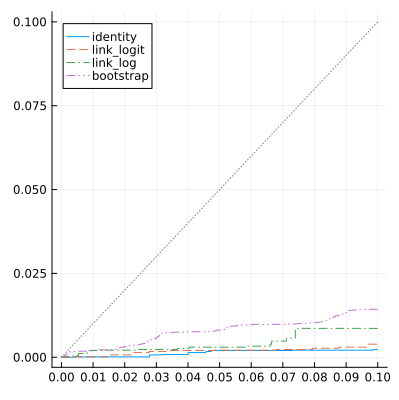

In [141]:
@show data = data1
mult = multinomial(data)
n, P = params(mult)
r = length(P)
@show n r
@show round.(P; sigdigits=2)
@time plot_pval(mult; niters=10000, L=10000,
    #sehatfunc = estimator_of_std_of_estimator_of_C, 
    sehatfunc = std_of_sdi_in_bootstrap, 
)

data = data2 = [6, 2]
n = 8
r = 2
round.(P; sigdigits = 2) = [0.75, 0.25]
  0.003771 seconds (48.16 k allocations: 2.080 MiB)


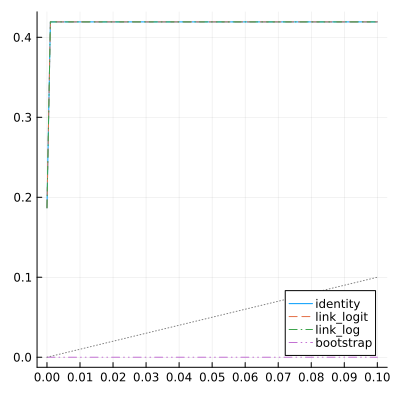

In [143]:
@show data = data2
mult = multinomial(data)
n, P = params(mult)
r = length(P)
@show n r
@show round.(P; sigdigits=2)
@time plot_pval(mult; niters=10000, L=0,
    sehatfunc = estimator_of_std_of_estimator_of_C, 
    #sehatfunc = std_of_sdi_in_bootstrap, 
)

data = data2 = [6, 2]
n = 8
r = 2
round.(P; sigdigits = 2) = [0.75, 0.25]
  0.866590 seconds (130.55 k allocations: 4.786 MiB, 1.12% gc time)


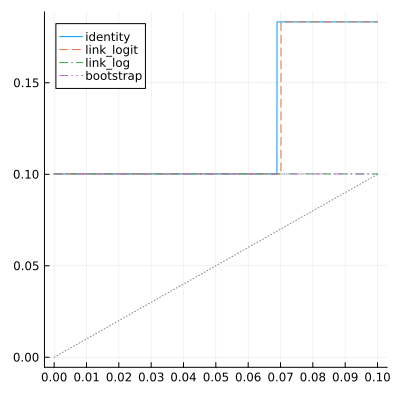

In [144]:
@show data = data2
mult = multinomial(data)
n, P = params(mult)
r = length(P)
@show n r
@show round.(P; sigdigits=2)
@time plot_pval(mult; niters=10000, L=10000,
    #sehatfunc = estimator_of_std_of_estimator_of_C, 
    sehatfunc = std_of_sdi_in_bootstrap, 
)

data = data3 = [12, 4, 1]
n = 17
r = 3
round.(P; sigdigits = 2) = [0.71, 0.24, 0.059]
  0.006410 seconds (106.16 k allocations: 3.159 MiB)


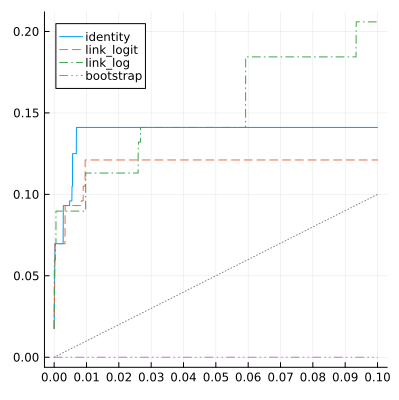

In [145]:
@show data = data3
mult = multinomial(data)
n, P = params(mult)
r = length(P)
@show n r
@show round.(P; sigdigits=2)
@time plot_pval(mult; niters=10000, L=0,
    sehatfunc = estimator_of_std_of_estimator_of_C, 
    #sehatfunc = std_of_sdi_in_bootstrap, 
)

data = data3 = [12, 4, 1]
n = 17
r = 3
round.(P; sigdigits = 2) = [0.71, 0.24, 0.059]
  1.800110 seconds (322.40 k allocations: 8.415 MiB)


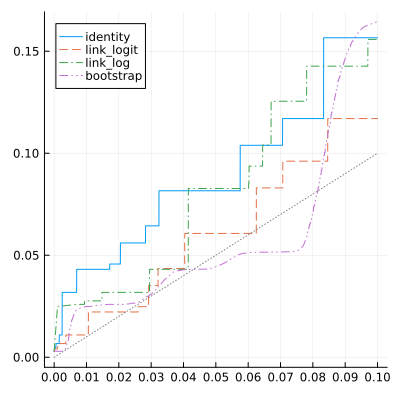

In [146]:
@show data = data3
mult = multinomial(data)
n, P = params(mult)
r = length(P)
@show n r
@show round.(P; sigdigits=2)
@time plot_pval(mult; niters=10000, L=10000,
    #sehatfunc = estimator_of_std_of_estimator_of_C, 
    sehatfunc = std_of_sdi_in_bootstrap, 
)

data = data4 = [5, 5, 3, 3]
n = 16
r = 4
round.(P; sigdigits = 2) = [0.31, 0.31, 0.19, 0.19]
  2.975590 seconds (401.17 k allocations: 10.636 MiB)


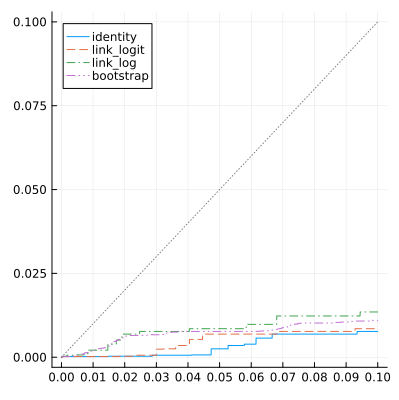

In [147]:
@show data = data4
mult = multinomial(data)
n, P = params(mult)
r = length(P)
@show n r
@show round.(P; sigdigits=2)
@time plot_pval(mult; niters=10000, L=10000,
    #sehatfunc = estimator_of_std_of_estimator_of_C, 
    sehatfunc = std_of_sdi_in_bootstrap, 
)

data = data5 = [6, 5, 4, 3]
n = 18
r = 4
round.(P; sigdigits = 2) = [0.33, 0.28, 0.22, 0.17]
  3.105925 seconds (459.89 k allocations: 11.711 MiB)


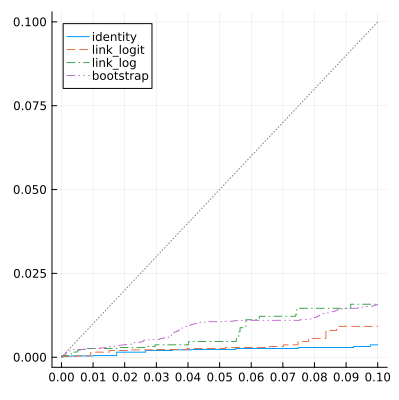

In [148]:
@show data = data5
mult = multinomial(data)
n, P = params(mult)
r = length(P)
@show n r
@show round.(P; sigdigits=2)
@time plot_pval(mult; niters=10000, L=10000,
    #sehatfunc = estimator_of_std_of_estimator_of_C, 
    sehatfunc = std_of_sdi_in_bootstrap, 
)

data = data6 = [10, 6, 2, 1, 1]
n = 20
r = 5
round.(P; sigdigits = 2) = [0.5, 0.3, 0.1, 0.05, 0.05]
  3.478085 seconds (589.74 k allocations: 14.157 MiB, 0.07% gc time)


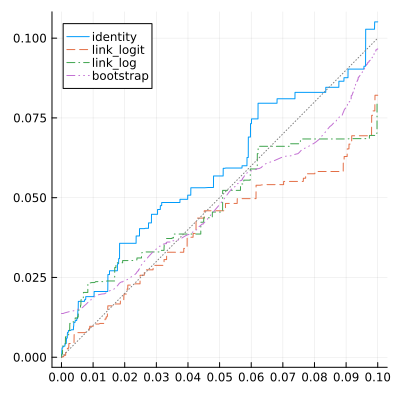

In [149]:
@show data = data6
mult = multinomial(data)
n, P = params(mult)
r = length(P)
@show n r
@show round.(P; sigdigits=2)
@time plot_pval(mult; niters=10000, L=10000,
    #sehatfunc = estimator_of_std_of_estimator_of_C, 
    sehatfunc = std_of_sdi_in_bootstrap, 
)

data = table1 = [9, 8, 7, 6, 5, 5, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
n = 117
r = 57
round.(P; sigdigits = 2) = [0.077, 0.068, 0.06, 0.051, 0.043, 0.043, 0.034, 0.034, 0.034, 0.026, 0.026, 0.026, 0.026, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085]


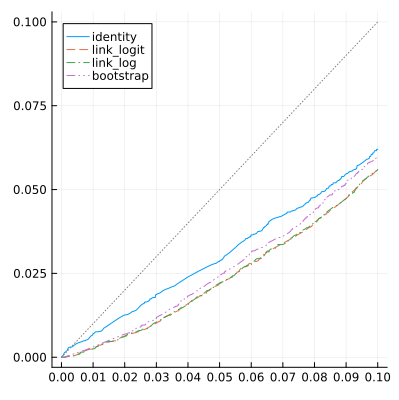

 41.223914 seconds (708.71 k allocations: 36.893 MiB, 0.02% gc time)


In [115]:
@show data = table1
mult = multinomial(data)
n, P = params(mult)
r = length(P)
@show n r
@show round.(P; sigdigits=2)
@time plot_pval(mult; niters=10000, L=10000,
    #sehatfunc = estimator_of_std_of_estimator_of_C, 
    sehatfunc = std_of_sdi_in_bootstrap, 
)

data = table2 = [37, 5, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
n = 117
r = 55
round.(P; sigdigits = 2) = [0.32, 0.043, 0.034, 0.034, 0.026, 0.026, 0.026, 0.026, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085]
 38.447319 seconds (380.26 k allocations: 30.769 MiB, 0.03% gc time)


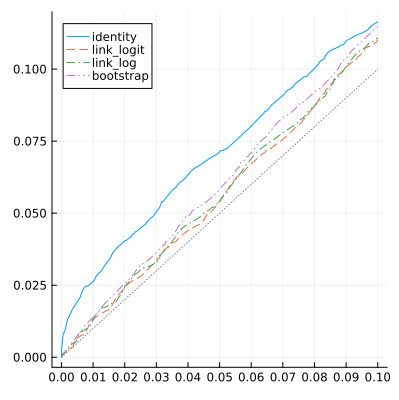

In [116]:
@show data = table2
mult = multinomial(data)
n, P = params(mult)
r = length(P)
@show n r
@show round.(P; sigdigits=2)
@time plot_pval(mult; niters=10000, L=10000,
    #sehatfunc = estimator_of_std_of_estimator_of_C, 
    sehatfunc = std_of_sdi_in_bootstrap, 
)

data = table3 = [30, 13, 9, 8, 7, 7, 7, 6, 6, 5, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
n = 117
r = 26
round.(P; sigdigits = 2) = [0.26, 0.11, 0.077, 0.068, 0.06, 0.06, 0.06, 0.051, 0.051, 0.043, 0.017, 0.017, 0.017, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085, 0.0085]
 22.300711 seconds (425.90 k allocations: 19.403 MiB, 0.03% gc time)


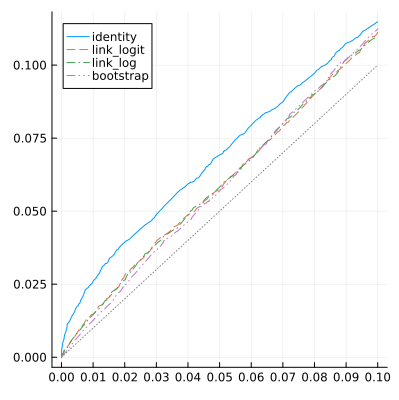

In [117]:
@show data = table3
mult = multinomial(data)
n, P = params(mult)
r = length(P)
@show n r
@show round.(P; sigdigits=2)
@time plot_pval(mult; niters=10000, L=10000,
    #sehatfunc = estimator_of_std_of_estimator_of_C, 
    sehatfunc = std_of_sdi_in_bootstrap, 
)